## Feature Ideas

- User level features (row per user, timestamp):
    - `userId`
    - `timestamp`
    - `months_since_account_creation`
    - `display_name_is_null` (careful this isn't a leak!)
    - `website_url_is_null`
    - `about_me_length`
    - `location_is_null`
    - `num_badges`
    - `weeks_since_last_badge`
    - `badge_score`: sum of log(1 / badge_incidence) -- captures a total of badges weighted by their rarity. Eg: let's say a user has two badges, one that 5% of users have and another that 1% of users have, then the badge_score is log(20) + log(100)

- Post level features (row per user, timestamp, postid for posts created before timestamp) - for later aggregation:
    - `userId`
    - `timestamp`
    - `postId`
    - `post_type`
    - `post_rank`: to sort posts by age
    - `has_accepted_ans`: questions only
    - `is_accepted_ans`: answers only
    - `num_tags`: questions only
    - `title_length`: questions only
    - `body_length`
    - `days_since_last_post`
    - `num_postive_votes`
    - `num_negative_votes`
    - `num_comments`
    - `avg_comment_length`
    - `num_distinct_commenters`
    - `avg_commenter_badge_score`


- **Proposed feature set** (row per user, timestamp):
    - `* from user_features`
    - Question feats:
        - last_question (feats as of the last question asked by user, NULL if not exists):
            - `weeks_ago`: how many weeks ago did the user post their last question 
            - `has_accepted_ans`
            - `num_tags`
            - `title_length`
            - `body_length`
            - `num_postive_votes`
            - `num_negative_votes`
            - `num_comments`
            - `avg_comment_length`
            - `num_distinct_commenters`
            - `avg_commenter_badge_score`
        - questions_last_6mo (aggregate feats over questions asked by user in the last 6 months, NULL otherwise):
            - `num_questions_last_6mo`
            - `avg_has_accepted_ans`
            - `avg_num_tags`
            - `avg_title_length`
            - `avg_body_length`
            - `avg_num_postive_votes`
            - `avg_num_negative_votes`
            - `avg_num_comments`
            - `avg_avg_comment_length`
            - `avg_num_distinct_commenters`
            - `avg_commenter_badge_score`
    - Answer feats:
        - last_answer (feats as of the last answer posted by user, NULL if not exists)
            - `weeks_ago`: how many weeks ago did the user post their last answer 
            - `is_accepted_ans`
            - `body_length`
            - `num_postive_votes`
            - `num_negative_votes`
            - `num_comments`
            - `avg_comment_length`
            - `num_distinct_commenters`
            - `avg_commenter_badge_score`
        - answers_last_3mo (aggregate feats over answeres posted by user in the last 3 months, NULL otherwise):
            - `num_answeres_last_3mo`
            - `acceptance_rate`
            - `avg_body_length`
            - `avg_num_postive_votes`
            - `avg_num_negative_votes`
            - `avg_num_comments`
            - `avg_avg_comment_length`
            - `avg_num_distinct_commenters`
            - `avg_commenter_badge_score`

        

In [ ]:
cd ..

In [9]:
import duckdb
import pandas as pd
from relbench.datasets import get_dataset
from torch_frame import TaskType, stype
from torch_frame.gbdt import LightGBM, XGBoost
from torch_frame.data import Dataset
from torch_frame.typing import Metric
from torch_frame.utils import infer_df_stype

In [3]:
conn = duckdb.connect('stackex.db')
FIRST_TIME = False  # if not, read it from stackex.db

if FIRST_TIME:
    dataset = get_dataset(name='rel-math-stackex', process=True)
    task = dataset.get_task('rel-stackex-engage', process=True)
    train_labels = task.train_table.df
    val_labels = task.val_table.df
    users = dataset.db.table_dict['users'].df
    posts = dataset.db.table_dict['posts'].df
    votes = dataset.db.table_dict['votes'].df
    badges = dataset.db.table_dict['badges'].df
    comments = dataset.db.table_dict['comments'].df
    conn.sql('create table train_labels as select * from train_labels')
    conn.sql('create table val_labels as select * from val_labels')
    conn.sql('create table users as select * from users')
    conn.sql('create table posts as select * from posts')
    conn.sql('create table votes as select * from votes')
    conn.sql('create table badges as select * from badges')
    conn.sql('create table comments as select * from comments')
    with open('round1_feats.sql', 'r') as query:
        # run once with train_labels and once with val_labels
        conn.sql(query.read())

In [4]:
train_df = conn.sql('select * from churn_feats_train').df()

In [5]:
val_df = conn.sql('select * from churn_feats_val').df()

In [10]:
col_to_stype = infer_df_stype(train_df)

In [11]:
col_to_stype

{'user_id': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'contribution': <stype.categorical: 'categorical'>,
 'months_since_account_creation': <stype.numerical: 'numerical'>,
 'display_name_is_null': <stype.categorical: 'categorical'>,
 'website_url_is_null': <stype.categorical: 'categorical'>,
 'about_me_length': <stype.numerical: 'numerical'>,
 'location_is_null': <stype.categorical: 'categorical'>,
 'num_badges': <stype.numerical: 'numerical'>,
 'badge_score': <stype.numerical: 'numerical'>,
 'weeks_since_last_comment': <stype.categorical: 'categorical'>,
 'num_comments': <stype.numerical: 'numerical'>,
 'num_posts_commented': <stype.numerical: 'numerical'>,
 'avg_comment_length': <stype.numerical: 'numerical'>,
 'last_q_weeks_ago': <stype.categorical: 'categorical'>,
 'last_q_has_accepted_ans': <stype.categorical: 'categorical'>,
 'last_q_num_tags': <stype.categorical: 'categorical'>,
 'last_q_title_length': <stype.numerical: 'numerical'>,
 'last_q

In [12]:
# Correct certain columns
col_to_stype.pop('user_id')
col_to_stype.pop('timestamp')
col_to_stype['weeks_since_last_comment'] = stype.numerical
col_to_stype['last_q_weeks_ago'] = stype.numerical
col_to_stype['last_q_num_tags'] = stype.numerical
col_to_stype['last_a_num_tags'] = stype.numerical

In [14]:
train_dset = Dataset(
    train_df.drop(['user_id', 'timestamp'], axis=1),
    col_to_stype=col_to_stype,
    target_col='contribution'
).materialize()
val_tf = train_dset.convert_to_tensor_frame(val_df.drop(['user_id', 'timestamp'], axis=1))
tune_metric = Metric.ROCAUC

print(train_dset.tensor_frame.num_cols, train_dset.tensor_frame.num_rows)
gbdt = XGBoost(TaskType.BINARY_CLASSIFICATION, num_classes=2, metric=tune_metric)
gbdt.tune(tf_train=train_dset.tensor_frame, tf_val=val_tf, num_trials=1)

[I 2024-04-10 08:43:35,190] A new study created in memory with name: no-name-aa282125-ab1a-4469-aad7-8f70d054ea89


54 300850


[I 2024-04-10 08:45:00,830] Trial 0 finished with value: 0.878076851125296 and parameters: {'booster': 'gbtree', 'use_lambda': True, 'lambda': 5.138949943270201e-06, 'use_alpha': True, 'alpha': 0.030536441617625563, 'max_depth': 3, 'min_child_weight': 3.401918560064873e-08, 'subsample': 0.6928036765610066, 'colsample_bytree': 0.8964352494415788, 'colsample_bylevel': 0.5752953649634576, 'use_gamma': False, 'learning_rate': 0.0013249969257018485}. Best is trial 0 with value: 0.878076851125296.
/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:45:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "use_alpha", "use_gamma", "use_lambda" } are not used.

  warnings.warn(smsg, UserWarning)


### Eval

In [42]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, average_precision_score, accuracy_score, PrecisionRecallDisplay

import utils

In [122]:
(
    utils
    .feature_summary_df(val_df.drop(['user_id', 'timestamp'], axis=1), 'contribution')
    .style
    .format('{:.3f}', subset=['Label Corr.', 'Label MI'])
    .format('{:.1%}', subset=['NaN %'])
)

/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



,Label Corr.,Label MI,NaN %
num_badges,0.229,0.057,0.0%
num_questions_last_6mo,0.209,0.067,89.7%
badge_score,0.206,0.069,0.0%
ans_acceptance_rate,0.195,0.094,96.4%
avg_comment_length,0.135,0.045,0.0%
num_posts_commented,0.131,0.061,0.0%
avg_num_tags,0.131,0.077,89.7%
avg_has_accepted_ans,0.130,0.106,89.7%
num_comments,0.130,0.057,0.0%
num_answers_last_6mo,0.125,0.037,96.4%


In [25]:
pred = gbdt.predict(tf_test=val_tf)

In [36]:
auc = gbdt.compute_metric(val_tf.y, pred)
y_ = val_tf.y.numpy()
pred_ = pred.numpy()
ap = average_precision_score(y_, pred_)
acc = accuracy_score(y_, (pred_ > 0.5))

print(f"AUC: {auc:.3f}")
print(f"AP: {ap:.3f}")
print(f"Accuracy: {acc:.3f}")

AUC: 0.878
AP: 0.620
Accuracy: 0.911


In [41]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fpr, tpr, thresholds = roc_curve(y_, pred_)
fig.add_trace(
    go.Scatter(x=fpr, y=tpr, mode='lines')
)
fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=600, height=600
)
fig.show()

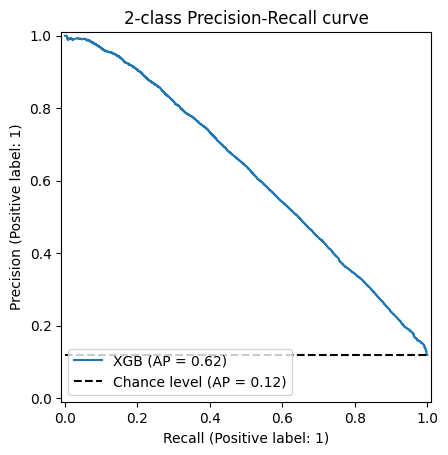

In [47]:
display = PrecisionRecallDisplay.from_predictions(
    y_, pred_, name='XGB', plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [49]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

In [64]:
val_arr, _, _ = gbdt._to_xgboost_input(val_tf[:5000])
shap_values = explainer.shap_values(val_arr, pred_[:5000])

In [69]:
# TODO verify
feat_names = val_tf.col_names_dict[stype.categorical] + val_tf.col_names_dict[stype.numerical]

/Users/adobles/opt/anaconda3/envs/relbench/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning:

All-NaN slice encountered



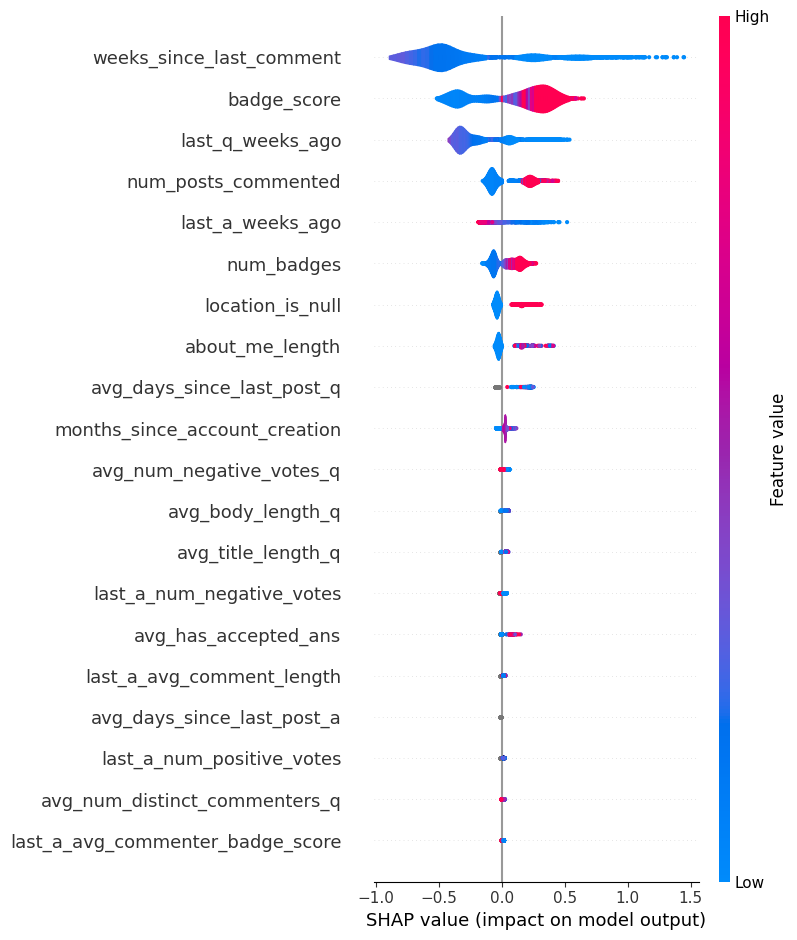

In [71]:
shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=20,
                  feature_names=feat_names)

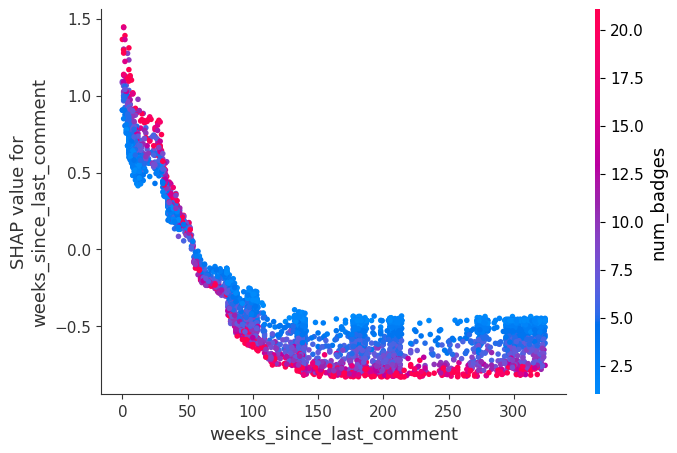

In [72]:
shap.dependence_plot('weeks_since_last_comment', shap_values, val_arr, feature_names=feat_names)

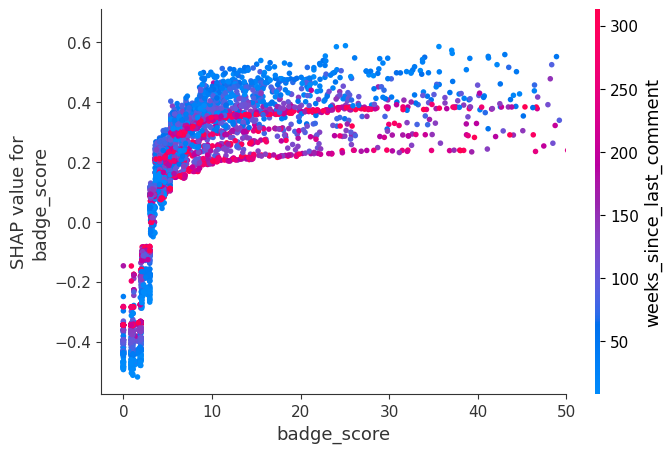

In [87]:
shap.dependence_plot('badge_score', shap_values, val_arr, feature_names=feat_names, xmin=0, xmax=50)

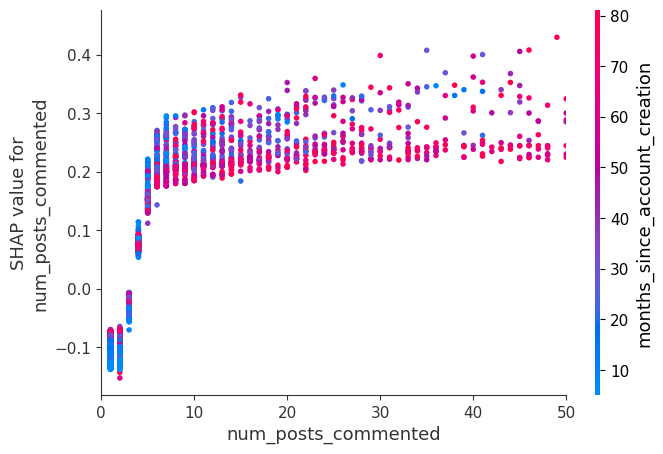

In [90]:
shap.dependence_plot('num_posts_commented', shap_values, val_arr, feature_names=feat_names,
                     interaction_index='months_since_account_creation', xmin=0, xmax=50)

In [127]:
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [137]:
%%sql
-- num users who have never posted
select
    count(*) as total_users,
    sum((p.OwnerUserId is null)::int) as never_posted,
    never_posted / count(*) as pct_never_posted,
    sum((c.UserId is null)::int) as never_commented,
    never_commented / count(*) as pct_never_commented,
    sum((coalesce(p.OwnerUserId, c.UserId) is null)::int) never_nothing,
    never_nothing / count(*) as pct_never_nothing
from users
left join (select distinct OwnerUserId from posts) as p
    on users.Id = p.OwnerUserId
left join (select distinct UserId from comments) as c
    on users.Id = c.UserId

total_users,never_posted,pct_never_posted,never_commented,pct_never_commented,never_nothing,pct_never_nothing
439116,140546,0.32006576849852886,236811,0.5392903014237695,135354,0.3082420134998497


In [ ]:
conn.close()